In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.patches import Polygon
import pandas as pd

In [10]:
num_nodes = 8
num_elements = 6 #cst element
num_materials = 2
problem_type = 21 #plane stress
thickness = 0.5
num_load_bc = 2 #number of lolads applied
num_disp_bc = 2 #number of places displacement condition is applied
dofpn = 2 #degrees of freedom per node
tdof = num_nodes*dofpn #total degrees of freedom

In [3]:
COORD = np.loadtxt(fname = 'D:\\SAI TEJA\\DATA\\COORD.txt').astype(np.float32)
NCA = np.loadtxt(fname = 'D:\\SAI TEJA\\DATA\\NCA.txt').astype(np.int64)
MAT = np.loadtxt(fname = 'D:\SAI TEJA\DATA\MAT.txt').astype(np.float32)
LOAD_BC = np.loadtxt(fname = 'D:\SAI TEJA\DATA\LOAD_BC.txt').astype(np.float32)
DISP_BC = np.loadtxt(fname = 'D:\SAI TEJA\DATA\DISP_BC.txt').astype(np.float32)
#print(np.shape(NCA))
#print(COORD[0][1])
#N1 = NCA[1][1]
#print(N1)
      

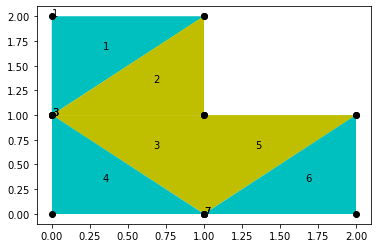

In [16]:
for ele in range(1,num_elements+1,1):
    
    # Nodes for each element from 1 to 6
    
    N1=NCA[ele,1]
    N2=NCA[ele,2]
    N3=NCA[ele,3]
    
    # Nodal coordinates for each element from 1 to 6
    
    X1N1=COORD[N1,1]
    X2N1=COORD[N1,2]
    X1N2=COORD[N2,1]
    X2N2=COORD[N2,2]
    X1N3=COORD[N3,1]
    X2N3=COORD[N3,2]
    
    #Assigning material for each element
    
    Mat_num=NCA[ele,4]
    
    #Verification of the geometry of the problem by plotting all the elements and nodes
    
    X=[X1N1,X1N2,X1N3]
    Y=[X2N1,X2N2,X2N3]
    CGX=(X1N1+X1N2+X1N3)/3
    CGY=(X2N1+X2N2+X2N3)/3
    if Mat_num==1:
        plt.fill(X,Y,'c')
    else:
        plt.fill(X,Y,'y')
    plt.scatter(X,Y,c='black')
    plt.text(CGX,CGY,str(ele))
    plt.text(X1N1,X2N1,str(N1))

In [11]:
GSTIFF=np.zeros((tdof,tdof)) # initialisition of Global stiffness matrix with all elements equal to zero
F=np.zeros(tdof) # initialisation of force matrix

In [18]:
for ele in range(1,num_elements+1,1):
    
    # Nodes for each element from 1 to 6
    
    N1=NCA[ele,1]
    N2=NCA[ele,2]
    N3=NCA[ele,3]
    
    # Nodal coordinates for each element from 1 to 6
    
    X1N1=COORD[N1,1]
    X2N1=COORD[N1,2]
    X1N2=COORD[N2,1]
    X2N2=COORD[N2,2]
    X1N3=COORD[N3,1]
    X2N3=COORD[N3,2]
    
    two_delta_matrix = np.array([[1,X1N1,X2N1],[1,X1N2,X2N2],[1,X1N3,X2N3]]) #creating 2delta matrix
    two_delta = np.linalg.det(two_delta_matrix) #calculating det of the matrix
    
    #calculation of B matrix
    
    B1 = X2N2-X2N3 #calculation of Beta values
    B2 = X2N3-X2N1
    B3 = X2N1-X2N2
    G1 = X1N3-X1N2 #calculation of Gamma values
    G2 = X1N1-X1N3
    G3 = X1N2-X1N1
    B = np.zeros((3,6)) #initialisation of B matrix to Zero
    B[0,0] = B1 
    B[0,2] = B2
    B[0,4] = B3
    B[1,1] = G1
    B[1,3] = G2
    B[1,5] = G3
    B[2,0] = G1
    B[2,1] = B1
    B[2,2] = G2
    B[2,3] = B2
    B[2,4] = G3
    B[2,5] = B3
    B=B/two_delta #calculation if B matrix
    
    Mat_num=NCA[ele,4]
    E = MAT[Mat_num,1]
    PR = MAT[Mat_num,2]
    CONST = E/(1-PR**2)
    D = np.zeros((3,3))
    D[0,0] = 1
    D[0,1] = PR
    D[1,0] = PR
    D[1,1] = 1
    D[2,2] = (1-PR)/2
    D=D*CONST
    
    ESTIFF=B.transpose()@D@B*thickness*two_delta*0.5 # Element stiffness matrix
    
    #Assembly of Global Stiffness Matrix
    
    CN=[2*N1-2,2*N1-1,2*N2-2,2*N2-1,2*N3-2,2*N3-1]
    CN_IDX=np.array(6*CN).reshape(6,6)
    RN_IDX=CN_IDX.transpose()
    GSTIFF[RN_IDX,CN_IDX]=GSTIFF[RN_IDX,CN_IDX]+ESTIFF
    
    
    
    

In [20]:
for i in range (1,num_load_bc+1,1):
    load_type = LOAD_BC[i,2]
    if load_type==1:
        N=int(LOAD_BC[i,1])
        F[(2*N-2)]=F[(2*N-2)]+LOAD_BC[i,3] #Assembly of Global Force Vector
    elif load_type==2:
        N=int(LOAD_BC[i,1])
        F[(2*N-1)]=F[(2*N-1)]+LOAD_BC[i,4]
    else:
        N=int(LOAD_BC[i,1])
        F[(2*N-2)]=F[(2*N-2)]+LOAD_BC[i,3]
        F[(2*N-1)]=F[(2*N-1)]+LOAD_BC[i,4]

In [21]:
GSTIFFCOPY=GSTIFF.copy() #Creating a copy of Global Stiffness matrix for solving

In [23]:
for i in range (1,num_disp_bc+1,1):
    disp_type = DISP_BC[i,2]
    if disp_type==1:
        N=int(DISP_BC[i,1])
        F[(2*N-2)]=F[(2*N-2)]+(DISP_BC[i,3]*10**16)
        GSTIFFCOPY[2*N-2,2*N-2]=GSTIFFCOPY[2*N-2,2*N-2]+10**16
    elif disp_type==2:
        N=int(DISP_BC[i,1])
        F[(2*N-1)]=F[(2*N-1)]+(DISP_BC[i,4]*10**16)
        GSTIFFCOPY[2*N-1,2*N-1]=GSTIFFCOPY[2*N-1,2*N-1]+10**16
    else:
        N=int(DISP_BC[i,1])
        F[(2*N-2)]=F[(2*N-2)]+(DISP_BC[i,3]*10**16)
        GSTIFFCOPY[2*N-2,2*N-2]=GSTIFFCOPY[2*N-2,2*N-2]+10**16
        F[(2*N-1)]=F[(2*N-1)]+(DISP_BC[i,4]*10**16)
        GSTIFFCOPY[2*N-1,2*N-1]=GSTIFFCOPY[2*N-1,2*N-1]+10**16

In [24]:
DISP=np.linalg.solve(GSTIFFCOPY,F)
print(DISP.reshape(-1,2))

[[-4.48840947e-14  7.50000000e-14]
 [ 4.48840947e-14 -1.50000000e-13]
 [-2.77843323e-08  1.68648926e-08]
 [-3.29053119e-08 -3.25785969e-08]
 [-2.91212666e-08 -1.53677003e-07]
 [-1.12493139e-07  2.21208037e-08]
 [-1.17749050e-07 -3.80604177e-08]
 [-1.26697371e-07 -1.58728683e-07]]


In [40]:
# calculation of stress and strain
strain=np.empty(shape=(3,0))
stress=np.empty(shape=(3,0))


In [36]:
for ele in range(1,num_elements+1,1):
    
    # Nodes for each element from 1 to 6
    
    N1=NCA[ele,1]
    N2=NCA[ele,2]
    N3=NCA[ele,3]
    
    # Nodal coordinates for each element from 1 to 6
    
    X1N1=COORD[N1,1]
    X2N1=COORD[N1,2]
    X1N2=COORD[N2,1]
    X2N2=COORD[N2,2]
    X1N3=COORD[N3,1]
    X2N3=COORD[N3,2]
    
    two_delta_matrix = np.array([[1,X1N1,X2N1],[1,X1N2,X2N2],[1,X1N3,X2N3]]) #creating 2delta matrix
    two_delta = np.linalg.det(two_delta_matrix) #calculating det of the matrix
    
    #calculation of B matrix
    
    B1 = X2N2-X2N3 #calculation of Beta values
    B2 = X2N3-X2N1
    B3 = X2N1-X2N2
    G1 = X1N3-X1N2 #calculation of Gamma values
    G2 = X1N1-X1N3
    G3 = X1N2-X1N1
    B = np.zeros((3,6)) #initialisation of B matrix to Zero
    B[0,0] = B1 
    B[0,2] = B2
    B[0,4] = B3
    B[1,1] = G1
    B[1,3] = G2
    B[1,5] = G3
    B[2,0] = G1
    B[2,1] = B1
    B[2,2] = G2
    B[2,3] = B2
    B[2,4] = G3
    B[2,5] = B3
    B=B/two_delta #calculation if B matrix
    print('B matrix for element',end=" ")
    print(ele)
    print(B)
    
    Mat_num=NCA[ele,4]
    E = MAT[Mat_num,1]
    PR = MAT[Mat_num,2]
    CONST = E/(1-PR**2)
    D = np.zeros((3,3))
    D[0,0] = 1
    D[0,1] = PR
    D[1,0] = PR
    D[1,1] = 1
    D[2,2] = (1-PR)/2
    D=D*CONST
    print('D matrix for element',end=" ")
    print(ele)
    print(D)
    
    u=np.array([DISP[2*N1-2],DISP[2*N1-1],DISP[2*N2-2],DISP[2*N2-1],DISP[2*N3-2],DISP[2*N3-1]]).reshape(6,1)
    print('u matrix for element',end=" ")
    print(ele)
    print(u)
    
    strain=np.concatenate([strain,np.array((B@u)).reshape(3,1)],axis=1)
    stress=np.concatenate([stress,np.array((D@B@u)).reshape(3,1)],axis=1)
    
    

B matrix for element 1
[[-1.  0.  0.  0.  1.  0.]
 [ 0.  1.  0. -1.  0.  0.]
 [ 1. -1. -1.  0.  0.  1.]]
D matrix for element 1
[[2.38095235e+11 9.52380952e+10 0.00000000e+00]
 [9.52380952e+10 2.38095235e+11 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.14285697e+10]]
u matrix for element 1
[[-4.48840947e-14]
 [ 7.50000000e-14]
 [-2.77843323e-08]
 [ 1.68648926e-08]
 [ 4.48840947e-14]
 [-1.50000000e-13]]
B matrix for element 2
[[-1.  0.  1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  1.]
 [ 0. -1. -1.  1.  1.  0.]]
D matrix for element 2
[[3.19999985e+11 7.99999962e+10 0.00000000e+00]
 [7.99999962e+10 3.19999985e+11 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.19999994e+11]]
u matrix for element 2
[[-2.77843323e-08]
 [ 1.68648926e-08]
 [-3.29053119e-08]
 [-3.25785969e-08]
 [ 4.48840947e-14]
 [-1.50000000e-13]]
B matrix for element 3
[[-1.  0.  0.  0.  1.  0.]
 [ 0.  0.  0. -1.  0.  1.]
 [ 0. -1. -1.  0.  1.  1.]]
D matrix for element 3
[[3.19999985e+11 7.99999962e+10 0.00000000e+00]
 [

In [37]:
print(strain)
print(stress)

[[ 8.97681893e-14 -5.12097956e-09 -5.12097956e-09 -5.25591109e-09
   3.78404524e-09 -8.94832038e-09]
 [-1.68648176e-08  3.25784469e-08  5.48182080e-09 -5.25591109e-09
   5.48182080e-09  5.05167997e-09]
 [ 2.77840624e-08 -1.65381328e-08  3.54002488e-08  2.45275854e-08
  -3.62546679e-08 -2.30921614e-08]]
[[-1606.15173503   967.56224452 -1200.16773906 -1751.97034361
   1649.44006161 -1649.44006161]
 [-4015.42416184 10015.42416184  1344.50422753 -1751.97034361
   2056.9061777    350.55993839]
 [ 1984.57583816 -1984.57583816  4248.02965639  1751.97034361
  -4350.55993839 -1649.44006161]]
